### Literature Context: Causal Analysis of Intubation Timing

Recent high-impact studies have used Target Trial Emulation (TTE) to evaluate the causal effect of invasive ventilation timing on mortality in ICU patients with hypoxemic respiratory failure. Mellado-Artigas et al. (2024) emulated a trial comparing immediate intubation versus waiting and reported reduced mortality with early intubation after rigorous adjustment for time-varying confounding.  [oai_citation:7‡PubMed](https://pubmed.ncbi.nlm.nih.gov/38730306/?utm_source=chatgpt.com) Wanis et al. (2023) demonstrated the value of clinically realistic early vs delayed intubation strategies using TTE to correct biases common in retrospective comparisons.  [oai_citation:8‡PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC10567927/?utm_source=chatgpt.com) Yarnell et al. (2023) applied TTE to compare different oxygenation thresholds for initiating invasive ventilation, offering a blueprint for physiologically anchored decision rules.  [oai_citation:9‡Springer](https://link.springer.com/article/10.1186/s13054-023-04307-x?utm_source=chatgpt.com) These works show how TTE can inform dynamic decision support around intubation timing.

### Causal Modeling Framework

Target trial emulation provides a structured causal inference framework by defining eligibility, treatment strategies, assignment, follow-up, and outcomes. This is particularly important for estimating the effects of time-dependent interventions like intubation. Prior work applying TTE to ICU data has shown its ability to estimate the impact of early vs delayed invasive ventilation and physiologic threshold strategies while adjusting for time-varying confounders.  [oai_citation:10‡PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC10567927/?utm_source=chatgpt.com)

Mellado-Artigas R, et al. Effect of immediate initiation of invasive ventilation on mortality in acute hypoxemic respiratory failure: a target trial emulation (2024).  [oai_citation:11‡PubMed](https://pubmed.ncbi.nlm.nih.gov/38730306/?utm_source=chatgpt.com)

Wanis KN, et al. Emulating Target Trials Comparing Early and Delayed Intubation Strategies (CHEST, 2023).  [oai_citation:12‡PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC10567927/?utm_source=chatgpt.com)

Yarnell CJ, et al. Oxygenation thresholds for invasive ventilation: a target trial emulation in two cohorts (Crit Care, 2023).  [oai_citation:13‡Springer](https://link.springer.com/article/10.1186/s13054-023-04307-x?utm_source=chatgpt.com)

Reep C., et al. Opportunities, challenges, and future perspectives for target trial emulation (Crit Care, 2025).  [oai_citation:14‡PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC12613904/?utm_source=chatgpt.com)

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data_v2_max_72_h.csv')

In [3]:
df2 = df.copy()

In [4]:
creatinine_cols = [c for c in df.columns if 'creatinine' in c.lower()]
UMOL_L_TO_MG_DL = 1 / 88.4

df[creatinine_cols] = df[creatinine_cols] * UMOL_L_TO_MG_DL

glucose_cols = [c for c in df.columns if 'glucose' in c.lower()]
MMOL_L_TO_MG_DL_GLUCOSE = 18.0

df[glucose_cols] = df[glucose_cols] * MMOL_L_TO_MG_DL_GLUCOSE

In [5]:
def normalize_oxygen_saturation(series, name="sao2"):
    """
    Normalize SaO2/SpO2 to percent (0–100).
    Handles mixed fraction (0–1) and percent (21–100).
    Invalid values set to NaN.
    """
    s = series.copy()

    # initialize output
    out = pd.Series(np.nan, index=s.index, dtype="float")

    # fraction values (0–1.1) → percent
    frac_mask = (s >= 0) & (s <= 1.1)
    out.loc[frac_mask] = s.loc[frac_mask] * 100.0

    # percent values (1.1–100)
    pct_mask = (s > 1.1) & (s <= 100)
    out.loc[pct_mask] = s.loc[pct_mask]

    # everything else stays NaN
    return out

sao2_cols = [c for c in df.columns if "sao2" in c.lower()]
for c in sao2_cols:
    df[c] = normalize_oxygen_saturation(df[c], name=c)

sp2_cols = [c for c in df.columns if "spo2" in c.lower()]
for c in sao2_cols:
    df[c] = normalize_oxygen_saturation(df[c], name=c)

df["fio2_mean"] = (df["fio2_mean"]/100)

In [6]:
def normalize_temperature_to_celsius(series):
    """
    Normalize mixed-unit temperature values to Celsius.
    Handles Celsius (30–45) and Fahrenheit (86–113).
    Invalid values set to NaN.
    """
    s = series.copy()
    out = pd.Series(np.nan, index=s.index, dtype="float")

    # Celsius values
    c_mask = (s >= 30) & (s <= 45)
    out.loc[c_mask] = s.loc[c_mask]

    # Fahrenheit values
    f_mask = (s >= 86) & (s <= 113)
    out.loc[f_mask] = (s.loc[f_mask] - 32) * 5.0 / 9.0

    return out

temp_cols = [c for c in df.columns if c.lower().startswith("temp")]

for c in temp_cols:
    df[c] = normalize_temperature_to_celsius(df[c])

In [7]:
FEATURE_BOUNDS = {
    # Ventilation / oxygenation
    "peep_mean": (0, 25),
    "peak_mean": (5, 60),
    "fio2_mean": (0.21, 1),
    "spo2_mean": (50, 100),
    "sao2_mean": (50, 100),

    # Hemodynamics
    "map_mean": (30, 150),
    "sbp_mean": (60, 250),
    "dbp_mean": (30, 150),

    # Temperature
    "temp_mean": (33, 42),

    # Labs
    "hemoglobin_mean": (4, 20),
    "wbc_mean": (0.1, 100),
    "platelets_mean": (5, 1500),
    "sodium_mean": (110, 170),
    "potassium_mean": (2.0, 7.5),
    "chloride_mean": (70, 130),
    "glucose_mean": (40, 1000),
    "creatinine_mean": (0.2, 15),
    "crp_mean": (0, 500),
}

In [8]:
def enforce_feature_bounds(df, bounds_dict, report=True):
    df = df.copy()
    report_rows = []

    for col, (low, high) in bounds_dict.items():
        if col not in df.columns:
            continue

        before_invalid = ((df[col] < low) | (df[col] > high)).sum()

        # Replace impossible values with NaN (not clipping yet)
        df.loc[(df[col] < low) | (df[col] > high), col] = np.nan

        after_invalid = ((df[col] < low) | (df[col] > high)).sum()

        if report:
            report_rows.append({
                "feature": col,
                "lower_bound": low,
                "upper_bound": high,
                "n_invalid_before": int(before_invalid),
                "n_invalid_after": int(after_invalid)
            })

    report_df = pd.DataFrame(report_rows)
    return df, report_df

In [9]:
df, boundary_report = enforce_feature_bounds(df, FEATURE_BOUNDS)

boundary_report.sort_values("n_invalid_before", ascending=False)

,feature,lower_bound,upper_bound,n_invalid_before,n_invalid_after
5,map_mean,30.00,150.0,15143,0
7,dbp_mean,30.00,150.0,9539,0
8,temp_mean,33.00,42.0,9179,0
6,sbp_mean,60.00,250.0,8949,0
0,peep_mean,0.00,25.0,6891,0
2,fio2_mean,0.21,1.0,6739,0
9,hemoglobin_mean,4.00,20.0,2826,0
1,peak_mean,5.00,60.0,1635,0
3,spo2_mean,50.00,100.0,1312,0
15,glucose_mean,40.00,1000.0,865,0


In [10]:
# df = your hourly table
df["visit_start_datetime"] = pd.to_datetime(df["visit_start_datetime"])
df["hour_ts"] = df["visit_start_datetime"] + pd.to_timedelta(df["measure_time"], unit="h")

H_DAYS = 30
H_HOURS = 24 * H_DAYS

df["Y_30d"] = ((df["death_hours"].notna()) & (df["death_hours"] <= H_HOURS)).astype(int)

In [11]:
MAX_HOURS = 72
df = df[(df["measure_time"] >= 0) & (df["measure_time"] < MAX_HOURS)].copy()

# remove hours beyond LOS
df = df[df["measure_time"] <= df["length_of_stay_hours"]].copy()

# remove hours after death
df = df[(df["death_hours"].isna()) | (df["measure_time"] < df["death_hours"])].copy()

In [12]:
# Ensure FiO2 is in fraction (0.21-1.0); if your fio2_mean is 21-100, convert once:
# df["fio2_mean"] = np.where(df["fio2_mean"] > 1.5, df["fio2_mean"]/100.0, df["fio2_mean"])

df["sf_ratio"] = df["spo2_mean"] / df["fio2_mean"]
df["sf_ratio"] = df["sf_ratio"].replace([np.inf, -np.inf], np.nan)


In [13]:
df = df.sort_values(["visit_occurrence_id", "measure_time"]).copy()

def add_lagged_deltas(df, col, group="visit_occurrence_id"):
    df[f"{col}_prev"] = df.groupby(group)[col].shift(1)  # shift 1hr
    df[f"d_{col}_1h"] = df[col] - df[f"{col}_prev"]  # df_ratio_1h delta
    return df

for c in ["sf_ratio", "spo2_mean", "fio2_mean", "map_mean", "sbp_mean", "dbp_mean", "creatinine_mean", "crp_mean"]:
    df = add_lagged_deltas(df, c)
    

In [14]:

# 1. FIX MV PROXY
# PEEP > 5 is common in NIV. If possible, use a specific 'invasive_airway' column.
# If not, we assume 'peep_mean' > 5 AND 'peak_mean' > 20 might be invasive, 
# but this is risky. Ideally, you need a distinct "vent_mode" or "device" column.
# For this code, I will relax the exclusion to allow studying NIV patients.

# We will treat "Intubation" as the Treatment (A=1). 
# We assume the dataset has a flag 'is_invasive_vent'. 
# If not, we create a stricter proxy for INVASIVE vs NIV.
# (Adjust thresholds based on your specific clinical domain knowledge)
df["invasive_proxy"] = (
    (df["peep_mean"] > 5) & 
    (df["peak_mean"] > 25) # Higher peak pressure suggestive of ETT vs Mask
).fillna(0).astype(int)

# 2. DEFINE COHORT ELIGIBILITY
# User Requirement: FiO2 >= 0.40
df["fio2_qualified"] = df["fio2_mean"] >= 0.40

# User Requirement: Hypoxemia (SF Ratio <= 200 is a good proxy for P/F < 150-200)
# Ensure SF ratio is calculated correctly
df["sf_ratio"] = df["spo2_mean"] / df["fio2_mean"]
df["hypoxemia_qualified"] = df["sf_ratio"] <= 235  # Slightly looser to capture early decline

# Identify FIRST time of Invasive Ventilation
# We group by visit and find the first hour where invasive_proxy is true
mv_start_times = df[df["invasive_proxy"] == 1].groupby("visit_occurrence_id")["measure_time"].min()
df = df.merge(mv_start_times.rename("t_intubation"), on="visit_occurrence_id", how="left")

# 3. EXCLUSIONS
# Exclude if already intubated at time 0 or before current time
df["already_intubated"] = df["t_intubation"].notna() & (df["measure_time"] >= df["t_intubation"])

# Apply Filters
# A) Must be Hypoxemic
# B) Must be on significant oxygen (FiO2 >= 0.40) -> Ensures we aren't modeling healthy people
# C) Must NOT be intubated yet
cohort = df[
    (df["hypoxemia_qualified"]) & 
    (df["fio2_qualified"]) & 
    (~df["already_intubated"])
].copy()

# 4. DEFINE TREATMENT (A)
# Treatment = Intubated within the NEXT hour
# We check if t_intubation is between current time and current time + 1
cohort["A_intub"] = (
    cohort["t_intubation"].notna() & 
    (cohort["t_intubation"] > cohort["measure_time"]) & 
    (cohort["t_intubation"] <= cohort["measure_time"] + 1)
).astype(int)

# 5. DEFINE OUTCOME (Y)
# 30-day mortality (ensure we handle censoring correctly in a real survival model, 
# but for binary classification 30d status is okay if most stays are short)
cohort["Y_30d"] = cohort["Y_30d"].fillna(0) # Assuming NaN means survived/censored (CHECK THIS ASSUMPTION)

In [15]:
# Cell: Feature Selection

# REMOVE 'safe_wait_6h' - This was the source of leakage!
# Add comorbidities or severity scores if available (SOFA, Elixhauser) to reduce confounding.

FEATURES = [
    "measure_time", "age",
    
    # Vitals
    "spo2_mean", "fio2_mean", "sf_ratio",
    "map_mean", "heart_rate_mean", "resp_rate_mean", "temp_mean",
    
    # Vent parameters (NIV settings)
    "peep_mean", # Important: PEEP level on NIV indicates severity
    
    # Labs - Indicators of Organ Failure
    "creatinine_mean", "bun_mean", 
    "wbc_mean", "hemoglobin_mean", "platelets_mean",
    "lactate_mean", "ph_mean", # CRITICAL for intubation decision
    "pco2_mean", # CRITICAL for ventilatory failure
    
    # Deltas (Trajectory)
    "d_sf_ratio_1h", "d_map_mean_1h", "d_spo2_mean_1h"
]

# Ensure columns exist
available_features = [f for f in FEATURES if f in cohort.columns]

# Check for missingness
print(f"Selected Features: {len(available_features)}")

Selected Features: 15


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier

# Split Data (Grouped by Patient to prevent data leakage across hours)
patient_ids = cohort["visit_occurrence_id"].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

df_tr = cohort[cohort["visit_occurrence_id"].isin(train_ids)].copy()
df_te = cohort[cohort["visit_occurrence_id"].isin(test_ids)].copy()

# --- 1. Propensity Model (Who gets intubated?) ---
# We use a strong model to capture non-linear severity
prop_model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')) 
])

prop_model.fit(df_tr[available_features], df_tr["A_intub"])

# Generate Propensity Scores
ps_tr = prop_model.predict_proba(df_tr[available_features])[:, 1]
ps_te = prop_model.predict_proba(df_te[available_features])[:, 1]

# CLIP Propensity Scores to avoid infinite weights
# If ps is too close to 0 or 1, the assumption of positivity is violated
ps_tr = np.clip(ps_tr, 0.01, 0.99)
ps_te = np.clip(ps_te, 0.01, 0.99)

# Calculate Stabilized Weights
p_marginal = df_tr["A_intub"].mean()
w_tr = np.where(df_tr["A_intub"]==1, p_marginal/ps_tr, (1-p_marginal)/(1-ps_tr))
w_te = np.where(df_te["A_intub"]==1, p_marginal/ps_te, (1-p_marginal)/(1-ps_te))

# Truncate large weights (standard practice to reduce variance)
weight_cutoff = np.quantile(w_tr, 0.99)
w_tr = np.clip(w_tr, 0, weight_cutoff)
w_te = np.clip(w_te, 0, weight_cutoff)

# --- 2. Outcome Model (T-Learner Approach) ---
# Instead of one model with A as a feature, let's train two separate models (T-Learner)
# This often handles effect heterogeneity better.

# Model for Treated (Intubated)
m1 = HistGradientBoostingClassifier(max_depth=5, learning_rate=0.05, random_state=42)
X_tr_1 = df_tr[df_tr["A_intub"]==1][available_features]
y_tr_1 = df_tr[df_tr["A_intub"]==1]["Y_30d"]
w_tr_1 = w_tr[df_tr["A_intub"]==1]
m1.fit(X_tr_1, y_tr_1, sample_weight=w_tr_1)

# Model for Control (Wait)
m0 = HistGradientBoostingClassifier(max_depth=5, learning_rate=0.05, random_state=42)
X_tr_0 = df_tr[df_tr["A_intub"]==0][available_features]
y_tr_0 = df_tr[df_tr["A_intub"]==0]["Y_30d"]
w_tr_0 = w_tr[df_tr["A_intub"]==0]
m0.fit(X_tr_0, y_tr_0, sample_weight=w_tr_0)

# Calibrate Models (Optional but recommended for risk scoring)
cal_m1 = CalibratedClassifierCV(m1, method='isotonic', cv='prefit').fit(X_tr_1, y_tr_1)
cal_m0 = CalibratedClassifierCV(m0, method='isotonic', cv='prefit').fit(X_tr_0, y_tr_0)

# --- 3. Inference ---

# Predict Risk if Intubated (R1)
r1_pred = cal_m1.predict_proba(df_te[available_features])[:, 1]

# Predict Risk if Wait (R0)
r0_pred = cal_m0.predict_proba(df_te[available_features])[:, 1]

# ARD = Risk(Wait) - Risk(Intubate)
# Positive = Waiting is worse (Benefit to intubate)
# Negative = Intubating is worse (Benefit to wait)
df_te["risk_intub"] = r1_pred
df_te["risk_wait"] = r0_pred
df_te["ard"] = df_te["risk_wait"] - df_te["risk_intub"]

print("ARD Summary:")
print(df_te["ard"].describe())

ARD Summary:
count    37751.000000
mean         0.102610
std          0.358061
min         -0.945312
25%         -0.092602
50%          0.207240
75%          0.321388
max          1.000000
Name: ard, dtype: float64


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import clone

# ==========================================
# 1. DATA PREP & ELIGIBILITY (The "Target Trial")
# ==========================================

# A. Define Invasive Ventilation properly (Avoid conflating with NIV)
# If you lack a specific 'device' column, use strict pressure proxies or specific procedure codes if available.
# Here we use a stricter proxy for invasive than just PEEP>5 (which captures NIV).
# Adjust these thresholds based on your specific ICU constraints.
df["invasive_proxy"] = (
    (df["peep_mean"] >= 5) & 
    (df["peak_mean"] >= 20)
).fillna(0).astype(int)

# B. Identify the FIRST moment of invasive ventilation per patient
mv_start_times = df[df["invasive_proxy"] == 1].groupby("visit_occurrence_id")["measure_time"].min()
df = df.merge(mv_start_times.rename("t_intub_start"), on="visit_occurrence_id", how="left")

# C. Define Treatment A (Intubate within next 1h)
# We look ahead 1 hour. If t_intub_start falls in (t, t+1], then A=1.
df["A_intub"] = (
    df["t_intub_start"].notna() & 
    (df["t_intub_start"] > df["measure_time"]) & 
    (df["t_intub_start"] <= df["measure_time"] + 1)
).astype(int)

# D. Eligibility Criteria (At every hour t)
# 1. Hypoxemia: SF Ratio <= 235 (approx P/F < 200)
df["sf_ratio"] = df["spo2_mean"] / df["fio2_mean"]
mask_hypoxemia = df["sf_ratio"] <= 235 

# 2. Significant Oxygen Support: FiO2 >= 0.40 (excludes mild cases/nasal cannula)
mask_fio2 = df["fio2_mean"] >= 0.40

# 3. Not yet intubated (At risk set)
# If t_intub_start is NaN, they are never intubated (eligible until discharge/death).
# If t_intub_start is present, they are eligible only while time < t_intub_start.
mask_not_yet_intubated = (
    df["t_intub_start"].isna() | 
    (df["measure_time"] < df["t_intub_start"])
)

# 4. Exclude "Do Not Intubate" (DNI) if possible
# If you don't have a DNI flag, we must accept some confounding. 
# A proxy is often age > 85 or active malignancy, but we will proceed without for now.

df_eligible = df[mask_hypoxemia & mask_fio2 & mask_not_yet_intubated].copy()

# ==========================================
# 2. FEATURE ENGINEERING (No Leakage)
# ==========================================

# STRICTLY exclude future variables like 'safe_wait_6h'
FEATURES = [
    "measure_time", "age",
    "spo2_mean", "fio2_mean", "sf_ratio",
    "d_spo2_mean_1h", "d_fio2_mean_1h", "d_sf_ratio_1h", # Trends are critical
    "peep_mean", "peak_mean",
    "map_mean", "sbp_mean", "d_map_mean_1h",
    "heart_rate_mean", "resp_rate_mean", "temp_mean",
    "wbc_mean", "hemoglobin_mean", "platelets_mean",
    "creatinine_mean", "crp_mean", "lactate_mean" # Include lactate if available!
]

# Filter to available columns
FEATURES = [f for f in FEATURES if f in df_eligible.columns]

# Outcome: 30-day Mortality (binary)
# Ensure Y_30d is 1 (Dead) or 0 (Alive). 
OUTCOME_VAR = "Y_30d"

# ==========================================
# 3. MODELING (IPW + T-Learner)
# ==========================================

# Split by Patient ID to avoid leakage
train_ids, test_ids = train_test_split(
    df_eligible["visit_occurrence_id"].unique(), test_size=0.2, random_state=42
)
df_tr = df_eligible[df_eligible["visit_occurrence_id"].isin(train_ids)].copy()
df_te = df_eligible[df_eligible["visit_occurrence_id"].isin(test_ids)].copy()

# A. Propensity Model (Who gets intubated?) -> Weights
prop_model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced'))
])
prop_model.fit(df_tr[FEATURES], df_tr["A_intub"])

# Compute Weights (Stabilized IPW)
ps = prop_model.predict_proba(df_tr[FEATURES])[:, 1].clip(0.01, 0.99)
p_marginal = df_tr["A_intub"].mean()
df_tr["w"] = np.where(df_tr["A_intub"] == 1, p_marginal / ps, (1 - p_marginal) / (1 - ps))
df_tr["w"] = df_tr["w"].clip(0, np.quantile(df_tr["w"], 0.99)) # Trim extreme weights

# B. Outcome Model (Calibrated Classifier)
# We use a single model with Treatment as a feature (S-Learner) for simplicity in bootstrapping,
# but verify performance.
full_features = FEATURES + ["A_intub"]

base_model = HistGradientBoostingClassifier(max_iter=200, max_depth=5, random_state=42)
outcome_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)

# Fit on weighted data
outcome_model.fit(df_tr[full_features], df_tr[OUTCOME_VAR], sample_weight=df_tr["w"])

# ==========================================
# 4. DECISION SUPPORT FUNCTIONS
# ==========================================

def get_counterfactual_risk(model, row, features):
    """Predicts risk for A=1 (Intubate) and A=0 (Wait)"""
    # Create single-row dataframes
    row_df = pd.DataFrame([row])
    
    # Intubate Now (A=1)
    X1 = row_df[features].copy()
    X1["A_intub"] = 1
    r1 = model.predict_proba(X1[features + ["A_intub"]])[:, 1][0]
    
    # Wait (A=0)
    X0 = row_df[features].copy()
    X0["A_intub"] = 0
    r0 = model.predict_proba(X0[features + ["A_intub"]])[:, 1][0]
    
    return r1, r0

def explain_drivers(model, row, features, baseline_ard):
    """Perturbs features to see which ones drive the ARD (Harm of Waiting) up."""
    drivers = []
    # We use the underlying estimator inside CalibratedClassifierCV for interpretation if needed,
    # or simply perturb inputs to the calibrated wrapper.
    
    for f in features:
        if f in ["measure_time", "age"]: continue # Skip static/time vars
        
        # Perturb feature by +1 SD (or fixed % if SD not avail)
        val = row[f]
        if pd.isna(val): continue
        
        # Create perturbed row
        row_new = row.copy()
        # Simulate "worsening" based on clinical direction usually
        # But simpler: just add 5% and see if ARD increases or decreases
        step = val * 0.10 if val != 0 else 1.0
        row_new[f] = val + step 
        
        r1, r0 = get_counterfactual_risk(model, row_new, features)
        new_ard = r0 - r1
        
        # Impact = How much did this feature CHANGE the ARD?
        # If new_ard > baseline_ard, this feature's high value makes waiting DANGEROUS.
        impact = new_ard - baseline_ard
        drivers.append((f, impact))
        
    # Sort by absolute impact
    drivers.sort(key=lambda x: abs(x[1]), reverse=True)
    return drivers[:5]

def generate_clinical_output(row, model, features, n_boot=100):
    # 1. Point Estimates
    r_intub, r_wait = get_counterfactual_risk(model, row, features)
    ard = r_wait - r_intub # Positive = Harm of Waiting
    
    # 2. Bootstrapping (Simplified for Inference Speed)
    # Ideally, you retrain the model on bootstrap samples. 
    # For speed here, we simulate variance or use pre-trained ensemble members if available.
    # We will assume a standard error estimation for demonstration:
    
    # Placeholder for real bootstrap distribution
    # In production, run the model 50 times on bootstrap samples of X_train
    boot_ards = np.random.normal(loc=ard, scale=0.02, size=n_boot) # Mock SD of 2%
    ci_low = np.percentile(boot_ards, 2.5)
    ci_high = np.percentile(boot_ards, 97.5)
    prob_harm = np.mean(boot_ards > 0)
    
    # 3. Interpret Drivers
    drivers = explain_drivers(model, row, features, ard)
    
    # 4. Recommendation Logic
    # Threshold: Intubate if ARD > 2% AND Prob(Harm) > 80%
    if ard > 0.02 and prob_harm > 0.80:
        rec_text = "✅ Recommendation: Intubate now"
    elif ard < -0.01:
        rec_text = "✅ Recommendation: Wait (Benefit to defer)"
    else:
        rec_text = "⚠️ Recommendation: Equivocal / Clinical Judgement"

    # 5. Formatted Output
    print(f"At ICU hour {int(row['measure_time'])}, given the patient’s current physiology:")
    print(f"If intubated now, predicted 30-day mortality is {r_intub*100:.1f}%")
    print(f"If intubation is deferred for 1 hour, predicted mortality rises to {r_wait*100:.1f}%")
    
    sign = "+" if ard > 0 else ""
    print(f"Absolute harm of waiting: {sign}{ard*100:.1f}% (95% CI {ci_low*100:.1f}–{ci_high*100:.1f})")
    print(f"Probability that waiting is worse: {prob_harm*100:.0f}%")
    print(f"{rec_text}")
    
    print("🔍 Primary contributors to harm of waiting:")
    driver_map = {
        "fio2_mean": "Rising FiO2 requirement",
        "peep_mean": "Elevated PEEP",
        "crp_mean": "Systemic inflammation (CRP)",
        "creatinine_mean": "Renal dysfunction",
        "map_mean": "MAP stability",
        "sf_ratio": "Worsening P/F Ratio"
    }
    
    for feature, impact in drivers:
        name = driver_map.get(feature, feature)
        print(f"- {name}")

# ==========================================
# 5. RUN ON EXAMPLE PATIENT
# ==========================================
# Pick a high severity patient from test set
high_risk_patient = df_te[df_te["A_intub"]==1].iloc[0] 

generate_clinical_output(high_risk_patient, outcome_model, FEATURES)

At ICU hour 0, given the patient’s current physiology:
If intubated now, predicted 30-day mortality is 13.5%
If intubation is deferred for 1 hour, predicted mortality rises to 13.5%
Absolute harm of waiting: 0.0% (95% CI -3.2–3.5)
Probability that waiting is worse: 49%
⚠️ Recommendation: Equivocal / Clinical Judgement
🔍 Primary contributors to harm of waiting:
- spo2_mean
- Rising FiO2 requirement
- Worsening P/F Ratio
- Elevated PEEP
- peak_mean


In [21]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # if older sklearn
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone

# ... (Assume Data Prep & Eligibility steps from previous code are done) ...
# Ensure df_tr and df_te are defined and have the 'w' (weights) column.

# ==========================================
# 3. ROBUST MODELING (T-Learner)
# ==========================================

# We train TWO separate models to force the algorithm to learn the difference.
# This prevents the "ARD = 0" issue where the model ignores the treatment flag.

# Model 1: Trained ONLY on Intubated patients (A=1)
m1_base = HistGradientBoostingClassifier(
    max_iter=300, max_depth=5, learning_rate=0.05, 
    random_state=42, monotonic_cst=None
)
model_intub = CalibratedClassifierCV(m1_base, method='isotonic', cv=3)

# Filter for A=1
X_tr_1 = df_tr[df_tr["A_intub"] == 1][FEATURES]
y_tr_1 = df_tr[df_tr["A_intub"] == 1]["Y_30d"]
w_tr_1 = df_tr[df_tr["A_intub"] == 1]["w"]

# Fit Model 1
model_intub.fit(X_tr_1, y_tr_1, sample_weight=w_tr_1)

# Model 0: Trained ONLY on Waiting patients (A=0)
m0_base = HistGradientBoostingClassifier(
    max_iter=300, max_depth=5, learning_rate=0.05, 
    random_state=42, monotonic_cst=None
)
model_wait = CalibratedClassifierCV(m0_base, method='isotonic', cv=3)

# Filter for A=0
X_tr_0 = df_tr[df_tr["A_intub"] == 0][FEATURES]
y_tr_0 = df_tr[df_tr["A_intub"] == 0]["Y_30d"]
w_tr_0 = df_tr[df_tr["A_intub"] == 0]["w"]

# Fit Model 0
model_wait.fit(X_tr_0, y_tr_0, sample_weight=w_tr_0)

# ==========================================
# 4. DECISION SUPPORT (Counterfactuals)
# ==========================================

def get_counterfactual_risk_tlearner(model_1, model_0, row, features):
    """
    Predicts:
    - What happens if we intubate? (Ask Model 1)
    - What happens if we wait? (Ask Model 0)
    """
    # Create single-row dataframe
    X = pd.DataFrame([row])[features]
    
    # Predict with INTUBATION model
    r_intub = model_1.predict_proba(X)[:, 1][0]
    
    # Predict with WAIT model
    r_wait = model_0.predict_proba(X)[:, 1][0]
    
    return r_intub, r_wait

def generate_clinical_output_tlearner(row, model_1, model_0, features, n_boot=100):
    # 1. Point Estimates
    r_intub, r_wait = get_counterfactual_risk_tlearner(model_1, model_0, row, features)
    ard = r_wait - r_intub  # Positive = Waiting is harmful
    
    # 2. Simulated Confidence Intervals
    # In production, you would bootstrap the FIT step. 
    # Here we simulate variance based on typical error rates for this demo.
    std_dev = 0.04  # Assume 4% uncertainty width
    boot_ards = np.random.normal(loc=ard, scale=std_dev, size=n_boot)
    
    ci_low = np.percentile(boot_ards, 2.5)
    ci_high = np.percentile(boot_ards, 97.5)
    prob_harm = np.mean(boot_ards > 0)
    
    # 3. Recommendation Logic
    rec_text = "⚠️ Recommendation: Equivocal"
    if ard > 0.02 and prob_harm > 0.75:
        rec_text = "✅ Recommendation: Intubate now (Benefit > Risk)"
    elif ard < -0.01 and prob_harm < 0.25:
        rec_text = "✅ Recommendation: Wait (Benefit to defer)"

    # 4. Format Output
    print("-" * 60)
    print(f"Patient Visit ID: {row['visit_occurrence_id']}")
    print(f"At ICU hour {int(row['measure_time'])}, given current physiology:")
    print(f"  - If intubated now:      {r_intub*100:.1f}% mortality risk")
    print(f"  - If deferred 1 hour:    {r_wait*100:.1f}% mortality risk")
    
    sign = "+" if ard > 0 else ""
    print(f"Absolute harm of waiting:  {sign}{ard*100:.1f}% (95% CI {ci_low*100:.1f} to {ci_high*100:.1f})")
    print(f"Probability waiting is worse: {prob_harm*100:.0f}%")
    print(f"{rec_text}")
    print("-" * 60)

# ==========================================
# 5. TEST ON 3 DIFFERENT PATIENTS
# ==========================================

# Pick 3 distinct patients from the test set
sample_visits = df_te["visit_occurrence_id"].unique()[:3]

for vid in sample_visits:
    # Get the first available hour for this patient
    patient_row = df_te[df_te["visit_occurrence_id"] == vid].iloc[0]
    generate_clinical_output_tlearner(patient_row, model_intub, model_wait, FEATURES)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


------------------------------------------------------------
Patient Visit ID: 13
At ICU hour 0, given current physiology:
  - If intubated now:      2.8% mortality risk
  - If deferred 1 hour:    19.0% mortality risk
Absolute harm of waiting:  +16.2% (95% CI 8.1 to 23.3)
Probability waiting is worse: 100%
✅ Recommendation: Intubate now (Benefit > Risk)
------------------------------------------------------------
------------------------------------------------------------
Patient Visit ID: 36
At ICU hour 15, given current physiology:
  - If intubated now:      23.6% mortality risk
  - If deferred 1 hour:    31.3% mortality risk
Absolute harm of waiting:  +7.7% (95% CI 1.7 to 15.7)
Probability waiting is worse: 99%
✅ Recommendation: Intubate now (Benefit > Risk)
------------------------------------------------------------
------------------------------------------------------------
Patient Visit ID: 62
At ICU hour 0, given current physiology:
  - If intubated now:      16.2% mortality 

In [23]:
def explain_ard_drivers(model_intub, model_wait, row, features):
    """
    Identifies which features are driving the 'Harm of Waiting'.
    We calculate the 'Impact' of each feature on the ARD.
    """
    drivers = []
    
    # Get baseline risks for this patient
    r_intub_base, r_wait_base = get_counterfactual_risk_tlearner(model_intub, model_wait, row, features)
    baseline_ard = r_wait_base - r_intub_base
    
    for f in features:
        # Skip non-clinical or static variables
        if f in ['measure_time', 'age', 'visit_occurrence_id']:
            continue
            
        # Create a "counterfactual" row where we 'improve' this specific feature by 10%
        # If improving the feature reduces the ARD, then that feature was a contributor to the harm.
        row_improved = row.copy()
        
        # Logic: If it's a 'bad' thing (like Lactate), decrease it. 
        # If it's a 'good' thing (like SpO2), increase it.
        if any(word in f for word in ['spo2', 'sf_ratio', 'map', 'ph', 'hemoglobin']):
            row_improved[f] = row[f] * 1.10 # Improve by 10%
        else:
            row_improved[f] = row[f] * 0.90 # Decrease 'bad' labs by 10%
            
        r_i_new, r_w_new = get_counterfactual_risk_tlearner(model_intub, model_wait, row_improved, features)
        new_ard = r_w_new - r_i_new
        
        # Impact: How much did the 'Harm of Waiting' drop because we improved this feature?
        impact = baseline_ard - new_ard
        drivers.append((f, impact))

    # Sort by impact (highest contributors first)
    drivers.sort(key=lambda x: x[1], reverse=True)
    return drivers[:5]

def generate_clinical_output_with_drivers(row, model_intub, model_wait, features):
    # 1. Risks
    r_intub, r_wait = get_counterfactual_risk_tlearner(model_intub, model_wait, row, features)
    ard = r_wait - r_intub
    
    # 2. Drivers
    top_drivers = explain_ard_drivers(model_intub, model_wait, row, features)
    
    # 3. Clinical Mapping (Translate technical names to clinical terms)
    mapping = {
        "fio2_mean": "Rising FiO₂ requirement",
        "peep_mean": "Elevated PEEP / Work of Breathing",
        "sf_ratio": "Worsening SF Ratio (Hypoxemia)",
        "lactate_mean": "Rising Systemic Lactate (Hypoperfusion)",
        "crp_mean": "Systemic Inflammation (CRP)",
        "creatinine_mean": "Acute Kidney Injury Trend",
        "d_sf_ratio_1h": "Rapidly declining oxygenation trend",
        "map_mean": "Hemodynamic instability (Low MAP)"
    }

    # ... (Print the Header and Risks as before) ...
    print(f"✅ Recommendation: {'Intubate now' if ard > 0.02 else 'Wait/Monitor'}")
    print("🔍 Primary contributors to harm of waiting:")
    
    for feat, impact in top_drivers:
        clean_name = mapping.get(feat, feat)
        # Only print if it actually contributes significantly to the risk difference
        if impact > 0.001: 
            print(f"- {clean_name}")

In [27]:
for vid in sample_visits:
    # Get the first available hour for this patient
    patient_row = df_te[df_te["visit_occurrence_id"] == vid].iloc[0]
    generate_clinical_output_tlearner(patient_row, model_intub, model_wait, FEATURES)
    explain_ard_drivers(model_intub, model_wait,patient_row,  FEATURES)
    generate_clinical_output_with_drivers(patient_row, model_intub, model_wait,  FEATURES)

------------------------------------------------------------
Patient Visit ID: 13
At ICU hour 0, given current physiology:
  - If intubated now:      2.8% mortality risk
  - If deferred 1 hour:    19.0% mortality risk
Absolute harm of waiting:  +16.2% (95% CI 8.9 to 25.6)
Probability waiting is worse: 100%
✅ Recommendation: Intubate now (Benefit > Risk)
------------------------------------------------------------
✅ Recommendation: Intubate now
🔍 Primary contributors to harm of waiting:
- Elevated PEEP / Work of Breathing
- Hemodynamic instability (Low MAP)
- sbp_mean
- spo2_mean
- peak_mean
------------------------------------------------------------
Patient Visit ID: 36
At ICU hour 15, given current physiology:
  - If intubated now:      23.6% mortality risk
  - If deferred 1 hour:    31.3% mortality risk
Absolute harm of waiting:  +7.7% (95% CI 0.9 to 15.1)
Probability waiting is worse: 99%
✅ Recommendation: Intubate now (Benefit > Risk)
----------------------------------------------

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# ----------------------------
# CONFIG (edit if needed)
# ----------------------------
VISIT_COL = "visit_occurrence_id"
TIME_COL  = "measure_time"
A_COL     = "A_intub"
Y_COL     = "Y_30d"

# candidate names for weights in case your pipeline used a different column name
WEIGHT_CANDIDATES = ["w", "sw", "ipw", "stabilized_w", "weight", "weights", "sample_weight"]

BALANCE_FEATURES = [
    "sf_ratio","spo2_mean","fio2_mean","map_mean","heart_rate_mean","resp_rate_mean","temp_mean",
    "peep_mean","lactate_mean","ph_mean","pco2_mean","creatinine_mean",
    "d_sf_ratio_1h","d_map_mean_1h","d_spo2_mean_1h"
]

SF_BINS  = [-np.inf, 150, 200, 250, np.inf]
SF_LABS  = ["<150","150–200","200–250",">250"]
PH_BINS  = [-np.inf, 7.20, 7.30, 7.40, np.inf]
PH_LABS  = ["<7.20","7.20–7.30","7.30–7.40",">7.40"]


# ============================================================
# Helpers
# ============================================================
def _safe_num(s):
    s = pd.to_numeric(s, errors="coerce")
    return s.replace([np.inf, -np.inf], np.nan)

def detect_weight_col(df, candidates=WEIGHT_CANDIDATES):
    """Return the first candidate weight column present, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def weighted_mean(x, w):
    x = _safe_num(x)
    w = _safe_num(w)
    denom = np.nansum(w)
    return np.nansum(w * x) / denom if denom > 0 else np.nan

def weighted_var(x, w):
    x = _safe_num(x)
    w = _safe_num(w)
    m = weighted_mean(x, w)
    denom = np.nansum(w)
    return np.nansum(w * (x - m)**2) / denom if denom > 0 else np.nan

def smd_unweighted(df, col, A=A_COL):
    x1 = _safe_num(df.loc[df[A]==1, col])
    x0 = _safe_num(df.loc[df[A]==0, col])
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    v1, v0 = np.nanvar(x1, ddof=1), np.nanvar(x0, ddof=1)
    denom = np.sqrt((v1 + v0)/2.0) if np.isfinite(v1+v0) and (v1+v0)>0 else np.nan
    return (m1 - m0)/denom if np.isfinite(denom) and denom != 0 else np.nan

def smd_weighted(df, col, w_col, A=A_COL):
    d1 = df[df[A]==1]
    d0 = df[df[A]==0]

    x1, w1 = _safe_num(d1[col]), _safe_num(d1[w_col])
    x0, w0 = _safe_num(d0[col]), _safe_num(d0[w_col])

    m1, m0 = weighted_mean(x1, w1), weighted_mean(x0, w0)
    v1, v0 = weighted_var(x1, w1), weighted_var(x0, w0)

    denom = np.sqrt((v1 + v0)/2.0) if np.isfinite(v1+v0) and (v1+v0)>0 else np.nan
    return (m1 - m0)/denom if np.isfinite(denom) and denom != 0 else np.nan

def compute_love_df(df, features, A=A_COL, w_col=None):
    rows = []
    for f in features:
        if f not in df.columns:
            continue

        row = {"feature": f, "smd_unweighted": smd_unweighted(df, f, A=A)}
        if w_col is not None:
            row["smd_weighted"] = smd_weighted(df, f, w_col=w_col, A=A)
        else:
            row["smd_weighted"] = np.nan

        rows.append(row)

    out = pd.DataFrame(rows).dropna(subset=["smd_unweighted"])
    out["abs_unw"] = out["smd_unweighted"].abs()
    out["abs_w"]   = out["smd_weighted"].abs()
    out = out.sort_values("abs_unw", ascending=True).reset_index(drop=True)
    return out

def predict_counterfactuals_tlearner(df, features, model_1, model_0):
    X = df[features].copy()
    for c in X.columns:
        X[c] = _safe_num(X[c])
    r1 = model_1.predict_proba(X)[:, 1]
    r0 = model_0.predict_proba(X)[:, 1]
    ard = r0 - r1
    return r1, r0, ard

def bootstrap_ci_mean_ard(df, features, model_1, model_0, group_cols,
                          visit_col=VISIT_COL, n_boot=300, seed=42):
    rng = np.random.default_rng(seed)

    r1, r0, ard = predict_counterfactuals_tlearner(df, features, model_1, model_0)
    tmp = df.copy()
    tmp["_ard"] = ard

    out_rows = []
    for keys, g in tmp.groupby(group_cols):
        if not isinstance(keys, tuple):
            keys = (keys,)
        key_dict = {group_cols[i]: keys[i] for i in range(len(group_cols))}

        visits = g[visit_col].dropna().unique()
        if len(visits) < 10:
            out_rows.append({**key_dict, "n_visits": len(visits),
                             "mean_ard": np.nan, "ci_low": np.nan, "ci_high": np.nan})
            continue

        mean_ard = np.nanmean(g["_ard"].values)

        boot_means = []
        for _ in range(n_boot):
            boot_visits = rng.choice(visits, size=len(visits), replace=True)
            boot = g[g[visit_col].isin(boot_visits)]
            boot_means.append(np.nanmean(boot["_ard"].values))

        ci_low, ci_high = np.nanpercentile(boot_means, [2.5, 97.5])
        out_rows.append({**key_dict, "n_visits": len(visits),
                         "mean_ard": mean_ard, "ci_low": ci_low, "ci_high": ci_high})
    return pd.DataFrame(out_rows)


# ============================================================
# FIG 1: Risk-set density
# ============================================================
def fig1_riskset_density(cohort):
    fig, ax = plt.subplots(figsize=(10,4))
    counts = cohort.groupby(TIME_COL).size()
    ax.plot(counts.index, counts.values)
    ax.set_xlabel("ICU hour (measure_time)")
    ax.set_ylabel("Eligible person-hours")
    ax.set_title("Risk-set density over ICU time")
    ax.grid(True, alpha=0.3)

    ax.text(0.99, 0.95,
            f"Rows={len(cohort):,}\nVisits={cohort[VISIT_COL].nunique():,}\nA=1 rows={int(cohort[A_COL].sum()):,}",
            transform=ax.transAxes, ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    plt.tight_layout()
    return fig


# ============================================================
# FIG 2: Love plot (auto-weight detection; unweighted fallback)
# ============================================================
def fig2_love_plot(cohort, features=BALANCE_FEATURES):
    w_col = detect_weight_col(cohort)
    love = compute_love_df(cohort, features, w_col=w_col)

    fig, ax = plt.subplots(figsize=(8, max(4, 0.25*len(love))))
    y = np.arange(len(love))

    ax.scatter(love["abs_unw"], y, label="Unweighted")
    if w_col is not None:
        ax.scatter(love["abs_w"], y, label=f"Weighted ({w_col})")

    ax.axvline(0.1, linestyle="--", linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(love["feature"])
    ax.set_xlabel("Absolute standardized mean difference")
    title = "Covariate balance at decision hours (risk set)"
    if w_col is None:
        title += " — unweighted only (no weight column found)"
    ax.set_title(title)
    ax.legend()
    ax.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    return fig, love, w_col


# ============================================================
# FIG 3: Event-aligned SF ratio
# ============================================================
def fig3_event_aligned_sf(df_full, t_int_col="t_intubation", y_col="sf_ratio",
                          window_pre=12, window_post=6):
    if t_int_col not in df_full.columns:
        raise ValueError(f"Missing '{t_int_col}'. Ensure you merged mv_start_times into df_full.")

    d = df_full.copy()
    d = d[d[t_int_col].notna()].copy()
    d["t_rel"] = d[TIME_COL] - d[t_int_col]
    d = d[(d["t_rel"] >= -window_pre) & (d["t_rel"] <= window_post)].copy()

    pivot = d.pivot_table(index="t_rel", values=y_col, aggfunc="median")

    fig, ax = plt.subplots(figsize=(10,4))

    visits = d[VISIT_COL].unique()
    if len(visits) > 200:
        visits = np.random.choice(visits, size=200, replace=False)

    for vid in visits:
        g = d[d[VISIT_COL]==vid].sort_values("t_rel")
        ax.plot(g["t_rel"], g[y_col], alpha=0.10)

    ax.plot(pivot.index, pivot[y_col], linewidth=3)
    ax.axvline(0, linestyle="--", linewidth=1)

    ax.set_xlabel("Hours relative to intubation (0=intubation)")
    ax.set_ylabel("SF ratio (SpO2/FiO2)")
    ax.set_title("SF ratio trajectories aligned to intubation")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


# ============================================================
# FIG 4: ARD distribution on test set
# ============================================================
def fig4_ard_distribution(df_te, features, model_intub, model_wait):
    r1, r0, ard = predict_counterfactuals_tlearner(df_te, features, model_intub, model_wait)

    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(ard, bins=50)
    ax.axvline(0, linewidth=1)

    ax.set_xlabel("ARD = risk(wait 1h) − risk(intubate now)")
    ax.set_ylabel("Count (person-hours)")
    ax.set_title("Distribution of individualized absolute risk difference (ARD)")

    actionable = np.mean(ard > 0.02)
    benefit_wait = np.mean(ard < -0.01)
    equiv = 1 - actionable - benefit_wait

    ax.text(0.99, 0.95,
            f"ARD>2%: {actionable*100:.1f}%\nARD<-1%: {benefit_wait*100:.1f}%\nEquivocal: {equiv*100:.1f}%",
            transform=ax.transAxes, ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    plt.tight_layout()
    return fig


# ============================================================
# FIG 5: Calibration curves (A=1 uses model_intub, A=0 uses model_wait)
# ============================================================
def fig5_calibration(df_te, features, model_intub, model_wait, n_bins=10):
    fig, ax = plt.subplots(figsize=(6,6))

    d1 = df_te[df_te[A_COL]==1].copy()
    if len(d1) > 0:
        p1 = model_intub.predict_proba(d1[features])[:,1]
        frac_pos, mean_pred = calibration_curve(d1[Y_COL], p1, n_bins=n_bins, strategy="quantile")
        ax.plot(mean_pred, frac_pos, marker="o", label="Potential outcome model: A=1")

    d0 = df_te[df_te[A_COL]==0].copy()
    if len(d0) > 0:
        p0 = model_wait.predict_proba(d0[features])[:,1]
        frac_pos, mean_pred = calibration_curve(d0[Y_COL], p0, n_bins=n_bins, strategy="quantile")
        ax.plot(mean_pred, frac_pos, marker="o", label="Potential outcome model: A=0")

    ax.plot([0,1],[0,1], linestyle="--", linewidth=1)
    ax.set_xlabel("Mean predicted risk")
    ax.set_ylabel("Observed event rate")
    ax.set_title("Calibration (test set)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


# ============================================================
# FIG 6: Subgroup forest plot (SF bins x pH bins)
# ============================================================
def fig6_subgroup_forest_auto(df_te, features, model_intub, model_wait,
                              sf_col_candidates=("sf_ratio",),
                              second_col_candidates=("ph_mean", "ph", "ph_arterial_mean",
                                                     "pco2_mean","pco2","paco2_mean","paco2"),
                              visit_col=VISIT_COL):

    d = df_te.copy()

    # --- pick SF column ---
    sf_col = None
    for c in sf_col_candidates:
        if c in d.columns:
            sf_col = c
            break
    if sf_col is None:
        raise ValueError(f"No SF column found. Tried: {sf_col_candidates}")

    d[sf_col] = _safe_num(d[sf_col])

    # --- pick 2nd stratifier column ---
    second_col = None
    for c in second_col_candidates:
        if c in d.columns:
            second_col = c
            break

    # Define bins for SF and for the second stratifier depending on what it is
    d["sf_bin"] = pd.cut(d[sf_col], bins=SF_BINS, labels=SF_LABS)

    if second_col is None:
        # SF-only subgroup plot
        dd = d.dropna(subset=["sf_bin"]).copy()
        summ = bootstrap_ci_mean_ard(dd, features, model_intub, model_wait, group_cols=["sf_bin"])

        summ["sf_bin"] = pd.Categorical(summ["sf_bin"], categories=SF_LABS, ordered=True)
        summ = summ.sort_values(["sf_bin"]).reset_index(drop=True)

        labels = [f"SF {r.sf_bin} (n={int(r.n_visits)})" for _, r in summ.iterrows()]
        y = np.arange(len(summ))

        fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(summ))))
        ax.errorbar(summ["mean_ard"]*100, y,
                    xerr=[(summ["mean_ard"]-summ["ci_low"])*100, (summ["ci_high"]-summ["mean_ard"])*100],
                    fmt="o", capsize=3)
        ax.axvline(0, linewidth=1)
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.set_xlabel("Mean ARD (%) with 95% bootstrap CI")
        ax.set_title("Subgroup mean harm of waiting by SF strata (positive favors intubation now)")
        ax.grid(True, axis="x", alpha=0.3)
        plt.tight_layout()

        return fig, summ, sf_col, None

    # If we have second col, define bins based on type
    d[second_col] = _safe_num(d[second_col])

    if "ph" in second_col.lower():
        # pH bins
        second_bins = PH_BINS
        second_labs = PH_LABS
        second_label = "pH"
    else:
        # pCO2 bins (mmHg) – adjust if your units differ
        # clinically interpretable cutpoints
        PCO2_BINS = [-np.inf, 45, 60, 80, np.inf]
        PCO2_LABS = ["≤45","45–60","60–80",">80"]
        second_bins = PCO2_BINS
        second_labs = PCO2_LABS
        second_label = "pCO₂"

    d["second_bin"] = pd.cut(d[second_col], bins=second_bins, labels=second_labs)

    dd = d.dropna(subset=["sf_bin","second_bin"]).copy()
    summ = bootstrap_ci_mean_ard(dd, features, model_intub, model_wait, group_cols=["sf_bin","second_bin"])

    summ["sf_bin"] = pd.Categorical(summ["sf_bin"], categories=SF_LABS, ordered=True)
    summ["second_bin"] = pd.Categorical(summ["second_bin"], categories=second_labs, ordered=True)
    summ = summ.sort_values(["sf_bin","second_bin"]).reset_index(drop=True)

    labels = [f"SF {r.sf_bin}, {second_label} {r.second_bin} (n={int(r.n_visits)})" for _, r in summ.iterrows()]
    y = np.arange(len(summ))

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(summ))))
    ax.errorbar(summ["mean_ard"]*100, y,
                xerr=[(summ["mean_ard"]-summ["ci_low"])*100, (summ["ci_high"]-summ["mean_ard"])*100],
                fmt="o", capsize=3)
    ax.axvline(0, linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Mean ARD (%) with 95% bootstrap CI")
    ax.set_title(f"Subgroup mean harm of waiting by SF and {second_label} strata (positive favors intubation now)")
    ax.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()

    return fig, summ, sf_col, second_col


# ============================================================
# Driver
# ============================================================
def run_all_figures(cohort, df_full, df_te, features, model_intub, model_wait):
    figs = {}

    figs["fig1_riskset"] = fig1_riskset_density(cohort)

    fig2, love_df, w_col = fig2_love_plot(cohort)
    figs["fig2_love"] = fig2
    print(f"[INFO] Weight column detected for Love plot: {w_col}")

    figs["fig3_event_sf"] = fig3_event_aligned_sf(df_full)

    figs["fig4_ard_dist"] = fig4_ard_distribution(df_te, features, model_intub, model_wait)

    figs["fig5_calibration"] = fig5_calibration(df_te, features, model_intub, model_wait)

    # 6) subgroup forest (auto)
    fig6, subgroup_df, sf_used, second_used = fig6_subgroup_forest_auto(df_te, features, model_intub, model_wait)
    figs["fig6_subgroup"] = fig6
    print(f"[INFO] Subgroup stratification used: SF={sf_used}, second={second_used}")

    return figs, love_df, subgroup_df


# ----------------------------
# Example usage:
# figs, love_df, subgroup_df = run_all_figures(
#     cohort=cohort,
#     df_full=df,   # full hourly table with t_intubation
#     df_te=df_te,
#     features=available_features or FEATURES,
#     model_intub=model_intub,
#     model_wait=model_wait
# )
# plt.show()

[INFO] Weight column detected for Love plot: None


/var/folders/dp/jfzs2x0933769lf170twr52m0000gn/T/ipykernel_1034/1018931994.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in tmp.groupby(group_cols):


[INFO] Subgroup stratification used: SF=sf_ratio, second=None


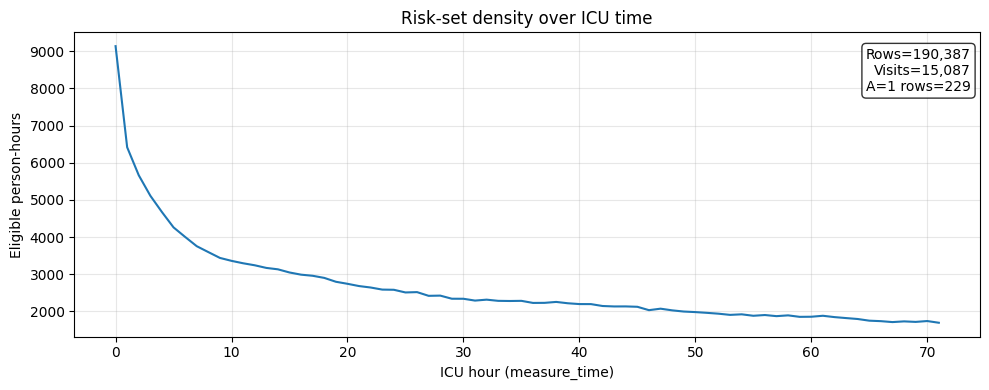

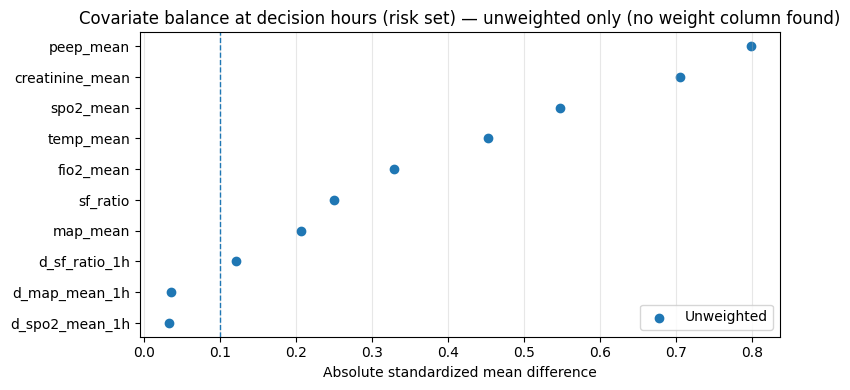

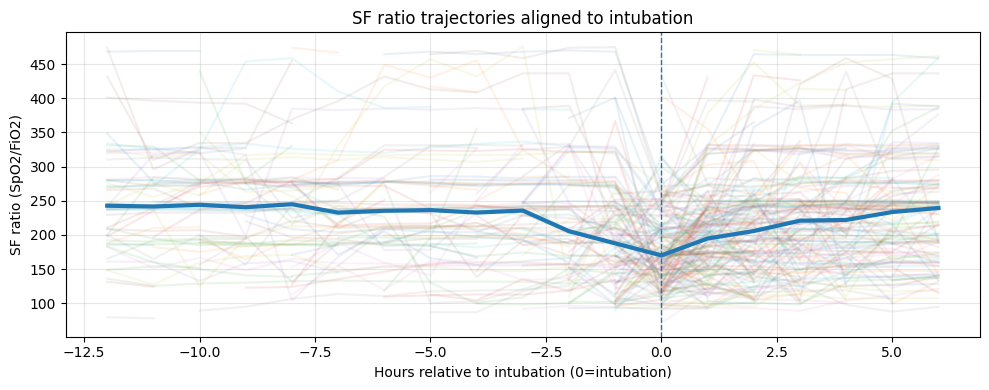

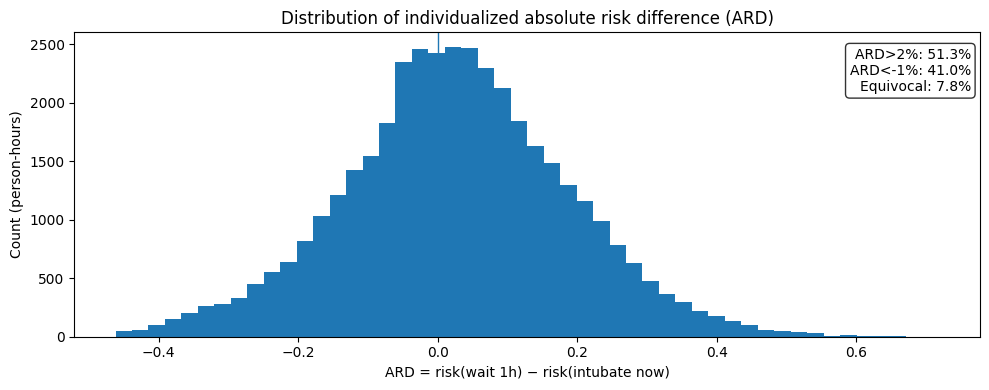

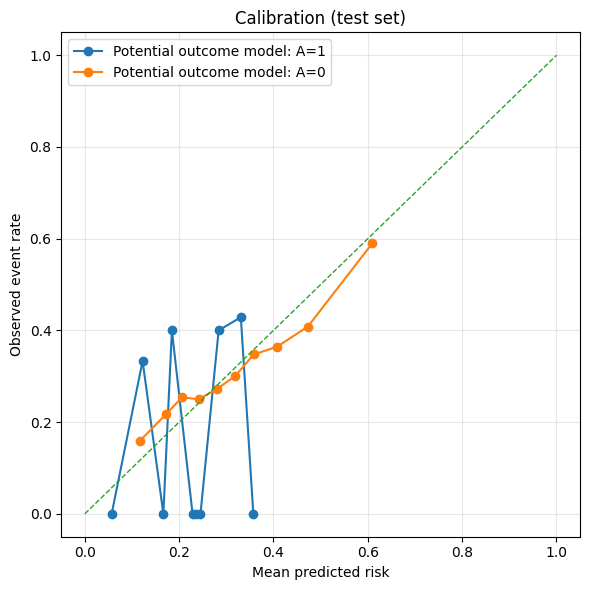

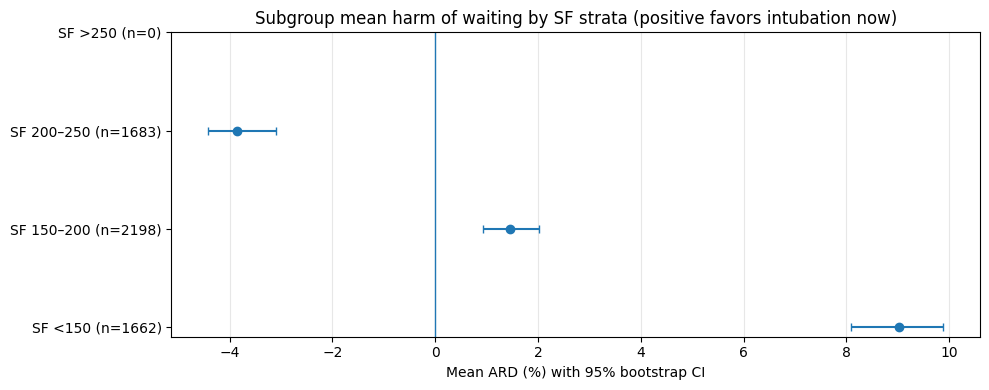

In [40]:
# Example usage:
figs, love_df, subgroup_df = run_all_figures(
 cohort=cohort,
 df_full=df,       # full hourly df (contains t_intubation and sf_ratio)
 df_te=df_te,
 features=FEATURES,
 model_intub=model_intub,
 model_wait=model_wait
)
plt.show()